In [3]:
%pylab inline
import pandas as pd
import time
import numpy as np
import pickle
import joblib
from joblib import Parallel, delayed
import os
import csv
import datetime as dt
from datetime import date, datetime, timedelta
from sklearn import svm, preprocessing
from collections import Counter
import seaborn as sns

plt.style.use('ggplot') 
pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
for dfname in ["vent_discharged", "sed_discharged", "vit_discharged", "sbt_discharged", "inputs_discharged"]:
    vars()[dfname] = pd.read_pickle("pickles/" + dfname + ".pkl")

vitals_list = ['Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure mean',
               'Non Invasive Blood Pressure systolic', 'Non Invasive Blood Pressure diastolic', 'Inspired O2 Fraction',
               'PEEP set', 'Mean Airway Pressure','Ventilator Mode', 'Tidal Volume (observed)','PH (Arterial)',
               'Respiratory Rate (spontaneous)','Richmond-RAS Scale','Peak Insp. Pressure', 'O2 Flow',
               'Plateau Pressure','Arterial O2 pressure','Arterial CO2 Pressure']
             # 'Temperature Celsius','Total PEEP Level'

seds_list = ['Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol',
                 'Fentanyl', 'Dexmedetomidine (Precedex)', 'Morphine Sulfate',
                 'Hydromorphone (Dilaudid)', 'Lorazepam (Ativan)']

sedatives = "Midazolam|Propofol|Dexmedetomidine|Hydromorphone|Morphine|Fentanyl|Lorazepam"

sbt_list = ['SBT Started', 'SBT Stopped', 'SBT Successfully Completed', 'SBT Deferred']

vent_discharged_hadms = vent_discharged.hadm.unique()

validIDs = pd.read_pickle("/tigress/BEE/usr/lifangc/workspace/mimic_experiment/vent_exp0002_k7_p0_s0/df/valid_id.pkl")

interpolated =['Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry',
       'Non Invasive Blood Pressure mean',
       'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic', 'Inspired O2 Fraction',
       'PEEP set', 'Tidal Volume (observed)', 'PH (Arterial)',
       'Arterial O2 pressure', 'Arterial CO2 Pressure']

resampled = ['Mean Airway Pressure', 'Ventilator Mode','Respiratory Rate (spontaneous)',
             'Richmond-RAS Scale','Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure']

In [4]:
imputedFrames = pd.read_pickle("pickles/imputedFrames.pkl")

In [ ]:
prefix = "/tigress/BEE/usr/lifangc/workspace/mimic_experiment/vent_exp0002_k7_p0_s0/df/vent_exp0002_k7_p0_s0_df_hadm_"
imputed = {}
#imputed = pd.concat([pd.read_pickle(prefix + str(h) + ".pkl") for h in validIDs[:5]])
i = 0
for h in validIDs:
    i = i + 1; print i
    imputed[h] = pd.read_pickle(prefix + str(h) + ".pkl")
#imputed
imputedC = pd.concat([imputed[h] for h in validIDs])

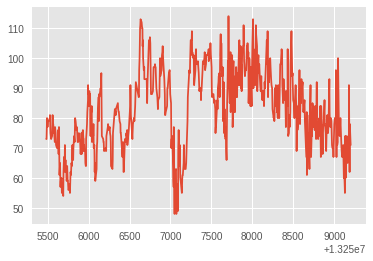

In [65]:
plot(vit_discharged[(vit_discharged.hadm == h) & (vit_discharged.label=='Heart Rate')].value)

In [ ]:
tmp = getChartFrame(h, vent_discharged, inputs_discharged, vit_discharged, sbt_discharged, vitals_list, seds_list, sbt_list)

In [34]:
# Gets time indices for dataframe:
def buildTimeFrame(start, end, delta):
    times = []
    curr = start
    while curr < end:
        times.append(curr)
        curr += delta
    timeFrame = DataFrame(data={'timestamp': times}, index=times)
    return timeFrame
        
# Gets relevant chart data for dataframe of hadm_id h:
def getChartFrame(h, ventTable, sedTable, vitTable, sbtTable, vitalsList, sedationList, sbtList):    
    # Get admit and discharge time in numeric form, round down/up respectively to the nearest hour:
    admitTime =  pd.to_datetime(ventTable[ventTable.hadm == h].admit_time.unique().item())
    admitTime -= dt.timedelta(minutes=admitTime.minute, seconds=admitTime.second, microseconds=admitTime.microsecond)
    
    dischTime = pd.to_datetime(ventTable[ventTable.hadm == h].discharge_time.unique().item())
    dischTime -= dt.timedelta(minutes=dischTime.minute, seconds=dischTime.second, microseconds=dischTime.microsecond)
    dischTime += dt.timedelta(mins = 10)
    
    chartFrame =  buildTimeFrame(admitTime, dischTime, timedelta(minutes=10))
    
    # Load in hadm, subj id, admit type and demographics: ethnicity, gender, age, [height, weight <-- TO DO]
    chartFrame['hadm'] = h
    chartFrame['subject'] = ventTable[ventTable.hadm == h].subject.head(1).item()
    chartFrame['admittype'] = ventTable[ventTable.hadm == h].admittype.head(1).item()
    chartFrame['adm_days'] = (dischTime - admitTime).days
    chartFrame['Ethnicity'] = ventTable[ventTable.hadm == h].subj_ethnicity.head(1).item()
    chartFrame['Gender'] = (ventTable[ventTable.hadm == h].gender.head(1).item()) # 0 for Male, 1 for Female
    chartFrame['Age'] = (ventTable[ventTable.hadm == h].admit_time.head(1).dt.year - 
                       ventTable[ventTable.hadm == h].dateofbirth.head(1).dt.year).item() % 210 # for censored >90s
    chartFrame['Weight'] = vitTable[(vitTable.hadm == h) & (vitTable.label.str.contains('Weight'))].head(1).value.item()

    print '1'
    chartFrame['Vented'] = 0
    # Add 'vented' indicator column
    for i,row in ventTable[ventTable.hadm == h].iterrows():
        ventStart = pd.to_datetime(row.vent_starttime)
        ventStart -= dt.timedelta(minutes=ventStart.minute, seconds=ventStart.second, microseconds=ventStart.microsecond)
        ventStart += dt.timedelta(hours = 1)
        ventEnd = pd.to_datetime(row.vent_endtime)
        ventEnd -= dt.timedelta(minutes=ventEnd.minute, seconds=ventEnd.second, microseconds=ventEnd.microsecond)
        for t in chartFrame.timestamp:
            if (pd.to_datetime(t) >= ventStart) and (pd.to_datetime(t) <= ventEnd): 
                chartFrame.loc[chartFrame.timestamp == t,'Vented'] = 1
    print '2'
    # Load in SBT info:
    chartFrame['SBT'] = np.nan
    for v in sbtList:
        sbt_t = sbtTable[(sbtTable.hadm == h) & (sbtTable.label == v)].sort_values(by='charttime')
        sbt_t.set_index('charttime',inplace=True,drop=False)
        sbt_t = sbt_t.resample('10min').mean()
        sbt_t = sbt_t[sbt_t['subject'].notnull()]
        sbt_t['timestamp'] = sbt_t.index
        for t in chartFrame.timestamp:
            if sbt_t[sbt_t.timestamp == t].empty == False:
                chartFrame.loc[chartFrame.timestamp == t,'SBT'] = v # overwrites if multiple things happen
    print '3'               
    # Load in resampled and interpolated vitals:
    for v in vitalsList:
        chartFrame[v] = np.nan
        vitals_v = vitTable[(vitTable.hadm == h) & (vitTable.label == v)].sort_values(by='charttime')
        vitals_v.set_index('charttime',inplace=True,drop=False)
        vitals_v = vitals_v.resample('10m').mean().fillna(method="ffill")    
        vitals_v['timestamp'] = vitals_v.index
        for t in chartFrame.timestamp:
            if vitals_v[vitals_v.timestamp == t].empty == False:
                chartFrame.loc[chartFrame.timestamp == t,v] = vitals_v[vitals_v.timestamp == t].value.item()
    print '4'
    # Load in sedation times, drugs (indicator column for each drug)
    sedValue = {}
    for s in sedationList:
        chartFrame[s] = 0
        for t in chartFrame.timestamp: sedValue[s,t] = 0
        for i,row in sedTable[(sedTable.hadm==h) & (sedTable.label==s)].iterrows():
            if not row.empty:
                sedStart = pd.to_datetime(row.input_start)
                sedEnd = pd.to_datetime(row.input_end)
                sedDur = (sedEnd - sedStart).seconds
                for t in chartFrame.timestamp:
                    if (pd.to_datetime(t) >= sedStart) and (pd.to_datetime(t) <= sedEnd): 
                        if row.ordercat == 'Continuous Med': 
                            sedValue[s,t] += float(row.amount)*3600/sedDur
                        elif row.ordercat == 'Drug Push':
                            sedValue[s,t] += float(row.amount)
                        chartFrame.loc[chartFrame.timestamp == t,s] = int(round(sedValue[s,t]))
    print '5'    
    tmp = chartFrame[chartFrame['Ventilator Mode'].notnull()].head(4)
    chartFrame = tmp.append(chartFrame.loc[chartFrame.loc[chartFrame['Ventilator Mode'].notnull()].index 
                                           + timedelta(mins=40)])
    return chartFrame 